In [ ]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional, Flatten
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
import gensim
from gensim.models import Word2Vec
from keras.utils import pad_sequences


In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [ ]:
dataset = load_dataset("ag_news")
df_test = pd.DataFrame(dataset['test'])
df_train_full = pd.DataFrame(dataset['train'])
df_train = df_train_full.groupby('label').apply(lambda x: x.sample(n=4000)).reset_index(drop=True)
df_train = pd.concat([df_train, df_test], axis=0)

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
df_train # 16000+7600

,text,label
0,"Asia-Pacific ministers talk trade, protesters ...",0
1,Maoist rebel blockade begins to pinch Nepal ca...,0
2,Laptops may damage male fertility Men who use ...,0
3,Dole Picked to Head 2006 Senate Campaigns (AP)...,0
4,Peacekeepers rushed to Haiti to halt looting H...,0
...,...,...
7595,Around the world Ukrainian presidential candid...,0
7596,Void is filled with Clement With the supply of...,1
7597,Martinez leaves bitter Like Roger Clemens did ...,1
7598,5 of arthritis patients in Singapore take Bext...,2


In [ ]:
df_train.label.value_counts()

0    5900
1    5900
2    5900
3    5900
Name: label, dtype: int64

In [ ]:
df_test.label.value_counts()

2    1900
3    1900
1    1900
0    1900
Name: label, dtype: int64

In [ ]:
df_train.shape

(23600, 2)

In [ ]:
from keras.utils import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split


In [ ]:
num_words=20000
tokenizer = text.Tokenizer(num_words)  # limit to the num_words most important ones
tokenizer.fit_on_texts(list(df_train['text']))
tokenized_texts = tokenizer.texts_to_sequences(df_train['text'])
X = pad_sequences(tokenized_texts, maxlen=100)

In [ ]:
list_classes = ["0", "1", "2", "3"]
y = pd.get_dummies(df_train["label"]).values

In [ ]:
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]], dtype=uint8)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.32, random_state=42)

In [ ]:
sentences = [row.split() for row in df_train_full['text']]
model_w2v = Word2Vec(sentences, vector_size=100, window=2, min_count=2, workers=4)
embedding_matrix = np.zeros((num_words, model_w2v.vector_size))
for i, word in enumerate(model_w2v.wv.index_to_key[:num_words-1]):
    embedding_vector = model_w2v.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i+1] = embedding_vector

In [ ]:
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(Embedding(input_dim=len(embedding_matrix), output_dim=100, weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(LSTM(128, return_sequences=True))
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))
adam = optimizers.Adam(learning_rate = 0.001)
#opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        234496    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         197120    
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              198144    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               3

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))


Epoch 1/10
126/126 [==============================] - 16s 36ms/step - loss: 0.9924 - accuracy: 0.5770 - val_loss: 0.7042 - val_accuracy: 0.7438
Epoch 2/10
126/126 [==============================] - 3s 23ms/step - loss: 0.5143 - accuracy: 0.8153 - val_loss: 0.5090 - val_accuracy: 0.8215
Epoch 3/10
126/126 [==============================] - 3s 24ms/step - loss: 0.3113 - accuracy: 0.8952 - val_loss: 0.4689 - val_accuracy: 0.8322
Epoch 4/10
126/126 [==============================] - 3s 23ms/step - loss: 0.2157 - accuracy: 0.9333 - val_loss: 0.4372 - val_accuracy: 0.8581
Epoch 5/10
126/126 [==============================] - 3s 23ms/step - loss: 0.1503 - accuracy: 0.9557 - val_loss: 0.4203 - val_accuracy: 0.8682
Epoch 6/10
126/126 [==============================] - 3s 23ms/step - loss: 0.1042 - accuracy: 0.9698 - val_loss: 0.4405 - val_accuracy: 0.8655
Epoch 7/10
126/126 [==============================] - 3s 24ms/step - loss: 0.0759 - accuracy: 0.9776 - val_loss: 0.6280 - val_accuracy: 0.858

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

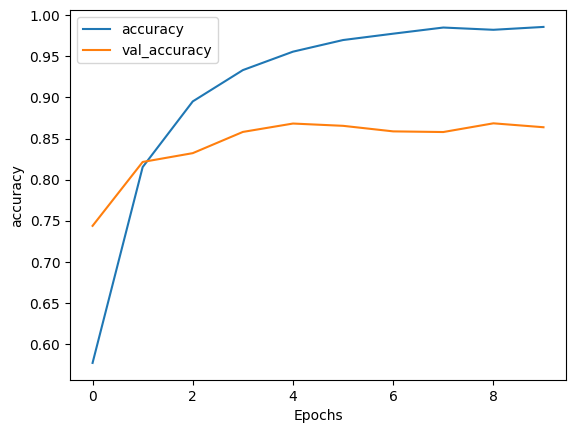

In [ ]:
plot_graphs(history, "accuracy")

In [ ]:
y_proba = model.predict(X_test)
y_pred = np.argmax(y_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

236/236 [==============================] - 4s 8ms/step


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
precision, recall, fscore, support= score(y_true, y_pred)
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1 score: {}".format(fscore))
print("Support: {}".format(support))
print("Accuracy score:{}".format(accuracy_score(y_true, y_pred)))

Precision: [0.84580153 0.90420679 0.85233751 0.85053763]
Recall: [0.87565859 0.95965573 0.7847769  0.83703704]
F1 score: [0.86047114 0.93110647 0.81716316 0.84373333]
Support: [1898 1859 1905 1890]
Accuracy score:0.8637447033898306


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_true=y_true, y_pred=y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1898
           1       0.90      0.96      0.93      1859
           2       0.85      0.78      0.82      1905
           3       0.85      0.84      0.84      1890

    accuracy                           0.86      7552
   macro avg       0.86      0.86      0.86      7552
weighted avg       0.86      0.86      0.86      7552

[[1662  103   82   51]
 [  44 1784   19   12]
 [ 133   62 1495  215]
 [ 126   24  158 1582]]
